Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


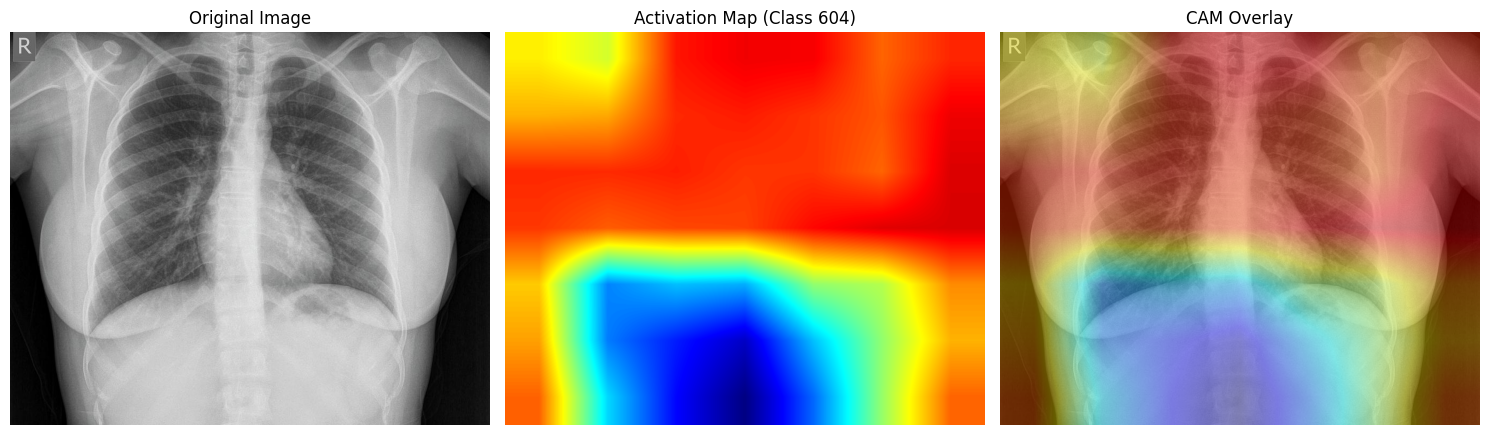

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

# Load pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()  # Set model to evaluation mode

# Global variable to store activations from the target layer
activations = None

def forward_hook(module, input, output):
    """Hook function to capture activations from the last convolutional layer."""
    global activations
    activations = output  # Save feature maps

# Register hook on the last convolutional layer of ResNet50
target_layer = model.layer4[2].conv3  # Last convolutional layer
target_layer.register_forward_hook(forward_hook)

# Function to preprocess the input image
def preprocess_image(img_path):
    """Loads and preprocesses an image for ResNet50."""
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

# Function to compute Class Activation Map (CAM)
def compute_cam(img_path):
    """Computes CAM by weighting feature maps with FC layer weights."""
    global activations

    img = preprocess_image(img_path)
    output = model(img)  # Forward pass
    class_idx = torch.argmax(output).item()  # Get predicted class index

    # Get weights from the fully connected layer
    fc_weights = model.fc.weight[class_idx].detach().numpy()  # Shape: (C,)

    # Extract feature maps from the last convolutional layer
    feature_maps = activations.squeeze(0).detach().numpy()  # Shape: (C, H, W)

    # Compute the weighted sum of feature maps
    cam = np.dot(fc_weights, feature_maps.reshape(feature_maps.shape[0], -1))
    cam = cam.reshape(feature_maps.shape[1], feature_maps.shape[2])  # Reshape to (H, W)

    # Apply ReLU and normalize
    cam = np.maximum(cam, 0)
    cam /= np.max(cam)

    return cam, class_idx

# Function to overlay the heatmap on the original image
def overlay_heatmap(img_path, cam):
    """Resizes CAM, applies a color map, and overlays it on the image."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize CAM to match image size
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam = np.uint8(255 * cam)  # Convert to 8-bit
    cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)  # Apply colormap

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img, 0.6, cam, 0.4, 0)

    return img, cam, overlay

# Function to display results using Matplotlib
def display_results(img_path, heatmap, overlay, class_idx):
    """Displays the original image, activation heatmap, and CAM overlay."""
    original = Image.open(img_path).convert('RGB')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(heatmap, cmap="jet")
    axes[1].set_title(f"Activation Map (Class {class_idx})")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("CAM Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Running the pipeline
img_path = "3-normal-healthy-chest-x-ray-photostock-israel.jpg"
heatmap, class_idx = compute_cam(img_path)
img, processed_heatmap, overlay = overlay_heatmap(img_path, heatmap)
display_results(img_path, processed_heatmap, overlay, class_idx)
